## Kaytoo | Model Evaluation & Validating Inference
### Bird Call Classification for New Zealand 
This notebook builds the inference code for Kaytoo, and evaluates its performance.  The final functions and classes for actual deployment are to be moved into seperate `.py` scripts, so I can import them consistently into the inference `.py` script for deployment.

## Basic Setup
Adjust the dictionary below for the overall notebook use case.  Note that I am processing different sound clips in parallel.  If using the GPU this results in multiple batches being sent to the GPU by different cores, so the number of cores needs to be reduced.  With 4Gb VRAM, max num_cores is 2.  This is still faster than CPU only with 6 cores.  

**Benchmarking on 39 x 15-minute .wav files on a Dell G7**

- 2-cores GPU = 55 seconds
- 6-cores CPU = 103 seconds

In [62]:
dummy_cell = 0

In [1]:
notebook_use = {
                'project_root': '/home/olly/Desktop/Kaggle_BC25', 
                'experiment': '39',
                'bird_name_csv': 'Data/Experiments/Exp_91/Exp_91_Deploy/exp_91_bird_map.csv',
                'folder_to_process': 'Data/Original_Data/birdclef-2025/train_soundscapes',
                'num_cores': 1  #Can crank this up if using CPU only.
                }

## Imports

In [2]:
#General Python
from pathlib import Path
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from IPython.display import Image, display
import re
import yaml

#External classes and functions
from bird_naming_utils import BirdNamer
from kaytoo_infer import  inference, ImageDataset, Models, get_images

#Math & Plotting
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

#Machine Learning 
#import albumentations as A
import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report

#Torch and PyTorch specific
#import timm
import torch
#import torch.nn as nn
#import torch.nn.functional as F
#import pytorch_lightning as pl
from torch.utils.data import  DataLoader
#from torchaudio.functional import compute_deltas

#Audio
import librosa
#import torchaudio
from scipy.signal import resample

print('Imports Complete')

Imports Complete


## Configuration Classes

In [3]:
class DefaultConfig:
    def __init__(self, bird_namer, options=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if options:
            if options['num_cores']:
                self.CORES = options['num_cores']
            else:
                self.CORES = 1
        self.classes = bird_namer.bird_list

In [4]:
class AudioParameters:
    def __init__(self):
        self.SR = 32000
        self.FMIN = 20
        self.FMAX = 14000 

In [5]:
class FilePaths:
    AUDIO_TYPES = {'.ogg','.wav', '.flac', '.mp3'}
    def __init__(self, options=None):
        self.root_folder = Path(options['project_root'])
        self.data_folder = self.root_folder / 'Data'
        self.train_audios = self.data_folder / 'Original_Data/birdclef-2025/train_audio'
        self.experiment_results = self.data_folder / f"Experiments/Exp_{options['experiment']}/Results"
        self.prev_model_preds = self.experiment_results / f"exp_{options['experiment']}_soundscape_predictions.csv"
        self.val_csv = self.experiment_results / 'val_labels.csv'
        self.bird_list_path = self.root_folder / options['bird_name_csv']
        self.soundscapes_folder = self.root_folder /options['folder_to_process']
        self.soundscapes = [path for path in self.soundscapes_folder.rglob('*') if path.suffix in self.AUDIO_TYPES]
        self.new_backgrounds = self.data_folder / 'Cropped_Train_Soundscapes'
        
        self.learning_rate_monitor = self.experiment_results / f"exp_{options['experiment']}_training_metrics.jpg"
        self.train_metric_monitor = self.experiment_results / 'learning_rate.jpg'
        self.val_preds = self.experiment_results / 'val_pred_df.pkl'
        self.val_targs = self.experiment_results / 'val_target_df.pkl'

## Helper Functions

In [6]:
class Colour:
    S = '\033[1m' + '\033[94m'
    E = '\033[0m'

## Initialise

In [7]:
audio = AudioParameters()
paths = FilePaths(options=notebook_use)
bird_map_df = pd.read_csv(paths.bird_list_path)
birdnames = BirdNamer(bird_map_df)

cfg = DefaultConfig(bird_namer=birdnames, 
                    options=notebook_use)


## Analysis of Training Metrics

### Class Sizes and Distributions

First lets look at the classes and their sizes.

In [8]:
bird_map_df = bird_map_df.sort_values(by='TrainSamples').reset_index(drop=True)
bird_map_df.head(50)

,eBird,CommonName,ScientificName,Class,TrainSamples,ValSamples
0,rutpuf1,Russet-throated Puffbird,Hypnelus ruficollis,aves,18,3.0
1,42007,Mountain Lion,Puma concolor,mamalia,19,2.0
2,1139490,Ragoniella pulchella,Ragoniella pulchella,insecta,20,0.0
3,21116,Yellow-striped Poison Dart Frog,Dendrobates truncatus,amphibia,20,0.0
4,1194042,Copiphora colombiae,Copiphora colombiae,insecta,20,0.0
5,47067,Brown-throated Three-toed Sloth,Bradypus variegatus,mamalia,20,0.0
6,476537,Colombian Plump Frog,Elachistocleis pearsei,amphibia,20,0.0
7,476538,Panama Humming Frog,Elachistocleis panamensis,amphibia,20,0.0
8,523060,Eschatoceras bipunctatus,Eschatoceras bipunctatus,insecta,20,0.0
9,piwtyr1,Pied Water-Tyrant,Fluvicola pica,aves,20,0.0


In [9]:
bird_map_df[bird_map_df['eBird']=='52884'] 

,eBird,CommonName,ScientificName,Class,TrainSamples,ValSamples
112,52884,True Crickets,Gryllidae,insecta,106,11.0


In [10]:
bird_map_df[bird_map_df['eBird']=='compot1'] 

,eBird,CommonName,ScientificName,Class,TrainSamples,ValSamples
186,compot1,Common Potoo,Nyctibius griseus,aves,430,47.0


In [11]:
rarest = bird_map_df[bird_map_df['TrainSamples'] + bird_map_df['ValSamples'] <= 50]['eBird'].to_list()
print(rarest)

['rutpuf1', '42007', '1139490', '21116', '1194042', '47067', '476537', '476538', '523060', 'piwtyr1', 'plctan1', '24272', '24322', '24292', '41778', '528041', 'turvul', '548639', '65349', '65419', 'shghum1', 'sahpar1', '555142', '64862', '65336', '65344', '81930', '868458', '714022', '787625', '963335', '66016', '65962', '65547', '41970', '1192948', '21038', '66531', '66578', '66893', '67082', '126247', '42113', '1346504', '134933', '42087', '1462711', '46010', '1462737', '1564122', 'norscr1', '67252', 'bubcur1', 'ampkin1', 'bafibi1', '566513', '135045', '65373', 'grysee1', '715170', 'blctit1', '555086', 'whmtyr1', 'royfly1', 'cocher1', '48124', 'olipic1', 'woosto']


In [12]:
from matplotlib.ticker import LogLocator

In [13]:
def plot_continuous(df, column_name, x_max=None, x_min=None, bins=None):
    plt.figure(figsize=(6, 4))
    ax = sns.histplot(df[column_name], bins=bins, kde=True)
    ax.set_yscale("log", base=2)  # Log scale with base 2
    ax.yaxis.set_major_locator(LogLocator(base=2.0, numticks=10))  # Control ticks
    plt.title(f'Distribution of {column_name} with {bins} Bins and KDE')
    plt.xlabel(column_name)
    ax.set(ylim=(1,40000))
    ax.set(xlim=(x_min, x_max) if x_min is not None and x_max is not None else None)
    plt.ylabel('Count')
    plt.show()

In [14]:
df = pd.read_csv(paths.prev_model_preds)
df.head()

,row_id,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
0,H27_20230421_155000_5,0.020572,0.016837,0.014559,0.009488,0.010178,0.041238,0.025885,0.014499,0.013865,...,0.063663,0.034133,0.088696,0.035924,0.056351,0.065219,0.071319,0.095855,0.111470,0.051263
1,H27_20230421_155000_10,0.031719,0.018931,0.010597,0.014670,0.004325,0.054781,0.017491,0.021448,0.019578,...,0.080267,0.039642,0.061492,0.047771,0.134586,0.056961,0.109637,0.122042,0.177380,0.051621
2,H27_20230421_155000_15,0.029602,0.027818,0.021443,0.014587,0.010736,0.048836,0.042596,0.037687,0.038311,...,0.077363,0.052125,0.082588,0.050315,0.184054,0.065636,0.089574,0.087746,0.109701,0.050292
3,H27_20230421_155000_20,0.016285,0.015355,0.020433,0.015314,0.012244,0.042301,0.035776,0.014482,0.018025,...,0.072951,0.044671,0.094467,0.085552,0.098358,0.094285,0.129215,0.110504,0.131080,0.083091
4,H27_20230421_155000_25,0.018294,0.014804,0.016544,0.026474,0.013208,0.041748,0.048837,0.018306,0.019768,...,0.058934,0.035821,0.058181,0.089575,0.066969,0.117313,0.103988,0.090833,0.139480,0.080824


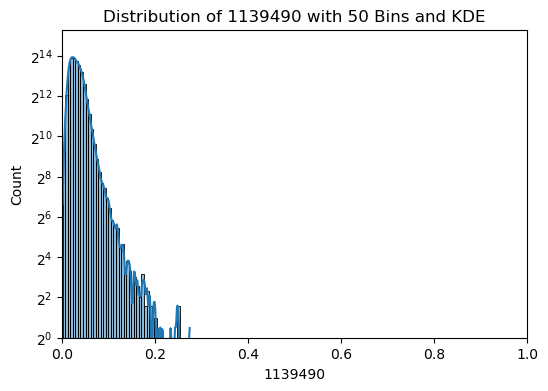

In [15]:
plot_continuous(df, '1139490', x_min = 0, x_max=1, bins=50)

In [16]:
#for bird in df.columns.to_list()[1:]:
#    print(bird)
#    plot_continuous(df.copy(), bird, x_min = 0, x_max=1, bins=50)

In [17]:
df_max = df.iloc[:, 1:].copy()
df_max['max_score'] = df_max.max(axis=1)
df_max.head(20)

,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,1564122,...,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar,max_score
0,0.020572,0.016837,0.014559,0.009488,0.010178,0.041238,0.025885,0.014499,0.013865,0.014633,...,0.034133,0.088696,0.035924,0.056351,0.065219,0.071319,0.095855,0.111470,0.051263,0.375984
1,0.031719,0.018931,0.010597,0.014670,0.004325,0.054781,0.017491,0.021448,0.019578,0.040641,...,0.039642,0.061492,0.047771,0.134586,0.056961,0.109637,0.122042,0.177380,0.051621,0.520848
2,0.029602,0.027818,0.021443,0.014587,0.010736,0.048836,0.042596,0.037687,0.038311,0.044589,...,0.052125,0.082588,0.050315,0.184054,0.065636,0.089574,0.087746,0.109701,0.050292,0.294739
3,0.016285,0.015355,0.020433,0.015314,0.012244,0.042301,0.035776,0.014482,0.018025,0.040071,...,0.044671,0.094467,0.085552,0.098358,0.094285,0.129215,0.110504,0.131080,0.083091,0.197572
4,0.018294,0.014804,0.016544,0.026474,0.013208,0.041748,0.048837,0.018306,0.019768,0.027087,...,0.035821,0.058181,0.089575,0.066969,0.117313,0.103988,0.090833,0.139480,0.080824,0.401039
5,0.017793,0.012033,0.010094,0.010817,0.008237,0.030134,0.028642,0.011900,0.013718,0.017750,...,0.020093,0.043654,0.091204,0.036502,0.075747,0.107993,0.083629,0.166505,0.083030,0.322577
6,0.017960,0.018673,0.032208,0.022865,0.032532,0.051441,0.084164,0.019088,0.027736,0.052717,...,0.071634,0.158111,0.070182,0.181774,0.075704,0.080515,0.117609,0.100455,0.078027,0.416157
7,0.029318,0.022309,0.015358,0.015080,0.011415,0.042204,0.026689,0.020678,0.023069,0.037289,...,0.020531,0.058047,0.065609,0.066313,0.089342,0.110976,0.129893,0.132323,0.080188,0.297592
8,0.027176,0.019966,0.011753,0.020816,0.004790,0.042739,0.019425,0.020586,0.017373,0.030724,...,0.022223,0.057119,0.100111,0.062921,0.092233,0.075952,0.074218,0.170035,0.070179,0.351102
9,0.028238,0.022252,0.015202,0.015889,0.008316,0.045592,0.026607,0.021804,0.023263,0.036185,...,0.029635,0.059102,0.119703,0.077415,0.079120,0.095568,0.097612,0.138027,0.068894,0.251203


In [18]:
df_max.shape

(97260, 207)

In [19]:
count = (df_max['max_score'] > 0.5).sum()
count

26233

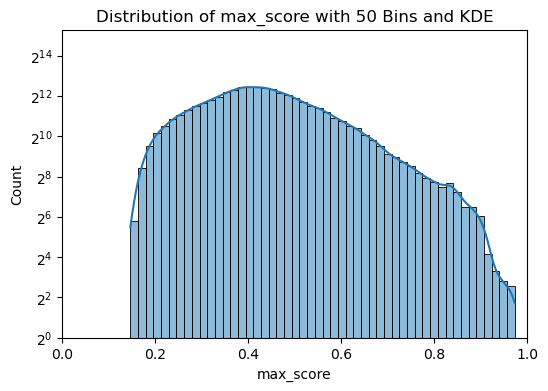

In [20]:
plot_continuous(df_max, 'max_score', x_min = 0, x_max=1, bins=50)

In [21]:
df_numeric = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')  # ensure numeric
df_max['second_from_max'] = df_numeric.apply(
    lambda row: row.nlargest(2).iloc[-1] if row.count() > 1 else row.max(),
    axis=1
)

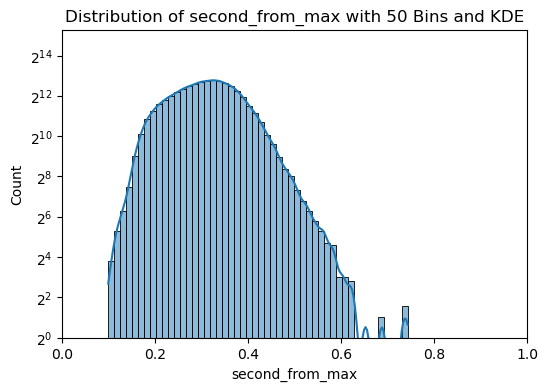

In [22]:
plot_continuous(df_max, 'second_from_max', x_min = 0, x_max=1, bins=50)

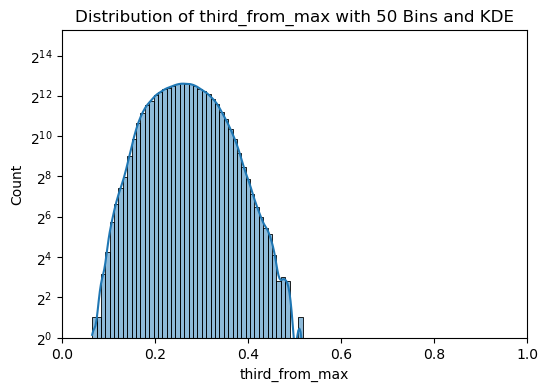

In [23]:
df_numeric = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')  # ensure numeric
df_max['third_from_max'] = df_numeric.apply(
    lambda row: row.nlargest(3).iloc[-1] if row.count() > 1 else row.max(),
    axis=1
)
plot_continuous(df_max, 'third_from_max', x_min = 0, x_max=1, bins=50)

In [24]:
df.head()

,row_id,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
0,H27_20230421_155000_5,0.020572,0.016837,0.014559,0.009488,0.010178,0.041238,0.025885,0.014499,0.013865,...,0.063663,0.034133,0.088696,0.035924,0.056351,0.065219,0.071319,0.095855,0.111470,0.051263
1,H27_20230421_155000_10,0.031719,0.018931,0.010597,0.014670,0.004325,0.054781,0.017491,0.021448,0.019578,...,0.080267,0.039642,0.061492,0.047771,0.134586,0.056961,0.109637,0.122042,0.177380,0.051621
2,H27_20230421_155000_15,0.029602,0.027818,0.021443,0.014587,0.010736,0.048836,0.042596,0.037687,0.038311,...,0.077363,0.052125,0.082588,0.050315,0.184054,0.065636,0.089574,0.087746,0.109701,0.050292
3,H27_20230421_155000_20,0.016285,0.015355,0.020433,0.015314,0.012244,0.042301,0.035776,0.014482,0.018025,...,0.072951,0.044671,0.094467,0.085552,0.098358,0.094285,0.129215,0.110504,0.131080,0.083091
4,H27_20230421_155000_25,0.018294,0.014804,0.016544,0.026474,0.013208,0.041748,0.048837,0.018306,0.019768,...,0.058934,0.035821,0.058181,0.089575,0.066969,0.117313,0.103988,0.090833,0.139480,0.080824


In [25]:
df.shape

(97260, 207)

In [26]:
threshold = 0.5
df_bin = df.copy()
# Identify numeric columns only
numeric_cols = df_bin.select_dtypes(include='number').columns

# Apply binary threshold
df_bin[numeric_cols] = (df_bin[numeric_cols] > threshold).astype(int)
df_bin = df_bin[~(df_bin.select_dtypes(include='number') == 0).all(axis=1)]
df_bin.head()

,row_id,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
1,H27_20230421_155000_10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36,H14_20230430_050500_35,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75,H67_20230516_212000_30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
82,H79_20230513_221000_15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94,H71_20230520_194500_25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


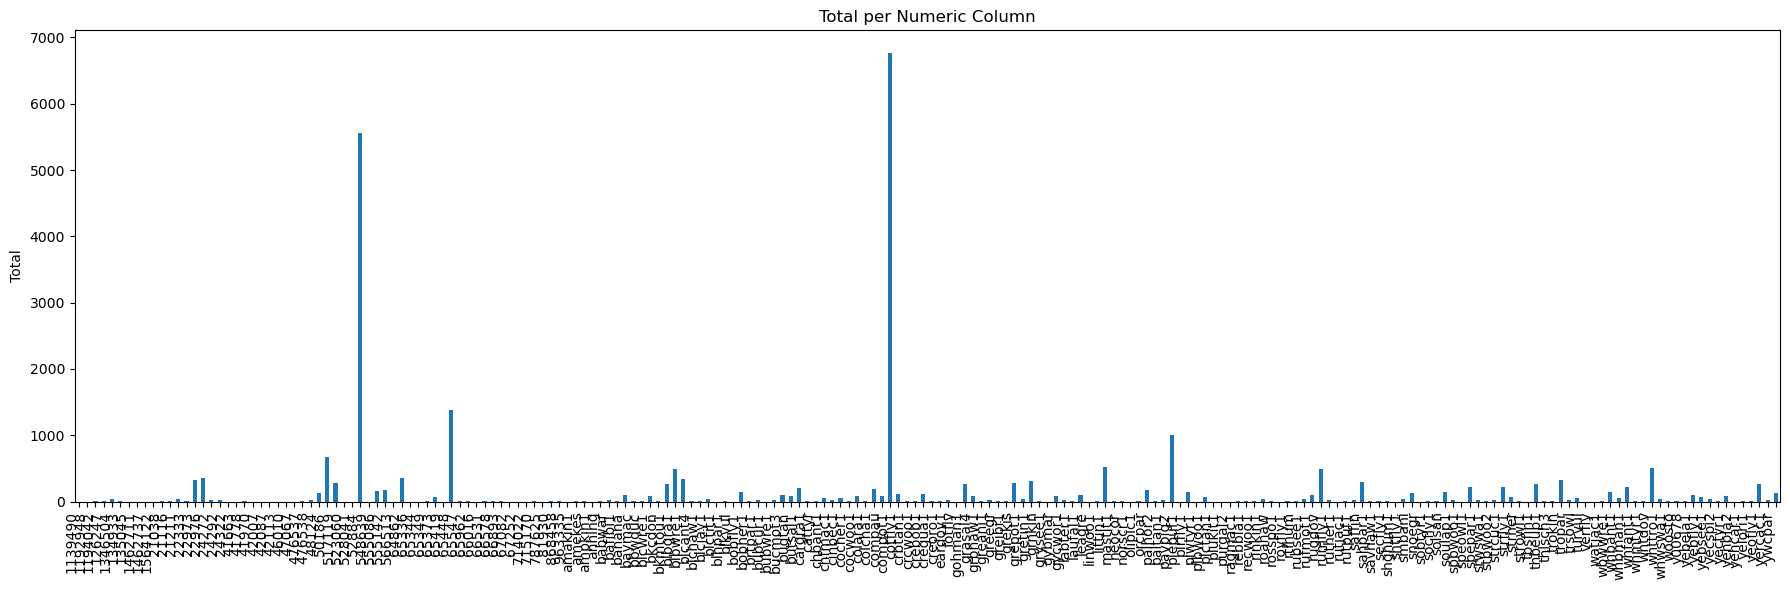

In [27]:
import matplotlib.pyplot as plt

# Sum each numeric column
column_totals = df_bin.select_dtypes(include='number').sum()

import matplotlib.pyplot as plt

# Set a wider figure size
plt.figure(figsize=(18, 6))  # Width=12 inches, Height=6 inches

# Sum and plot
column_totals = df_bin.select_dtypes(include='number').sum()
column_totals.plot(kind='bar')
plt.ylabel('Total')
plt.title('Total per Numeric Column')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

In [28]:
for total, name in zip(column_totals, df.columns.tolist()[1:]):
    print(name, total)

1139490 0
1192948 0
1194042 1
126247 6
1346504 39
134933 6
135045 0
1462711 0
1462737 0
1564122 0
21038 3
21116 2
21211 42
22333 2
22973 319
22976 350
24272 22
24292 23
24322 0
41663 0
41778 6
41970 0
42007 0
42087 0
42113 0
46010 0
47067 0
476537 15
476538 16
48124 125
50186 669
517119 272
523060 0
528041 0
52884 5556
548639 0
555086 155
555142 167
566513 0
64862 352
65336 0
65344 0
65349 3
65373 72
65419 0
65448 1376
65547 1
65962 5
66016 0
66531 1
66578 2
66893 2
67082 0
67252 0
714022 0
715170 2
787625 0
81930 13
868458 1
963335 0
amakin1 10
amekes 5
ampkin1 0
anhing 3
babwar 20
bafibi1 1
banana 105
baymac 11
bbwduc 1
bicwre1 90
bkcdon 2
bkmtou1 257
blbgra1 493
blbwre1 346
blcant4 3
blchaw1 1
blcjay1 45
blctit1 0
blhpar1 6
blkvul 0
bobfly1 142
bobher1 4
brtpar1 19
bubcur1 0
bubwre1 21
bucmot3 101
bugtan 80
butsal1 198
cargra1 2
cattyr 14
chbant1 58
chfmac1 20
cinbec1 48
cocher1 1
cocwoo1 89
colara1 6
colcha1 193
compau 88
compot1 6769
cotfly1 114
crbtan1 5
crcwoo1 10
crebob1 112
cr

compot1, has over 6000 samples.  But only 300 in the training data   It's some kind of owl, so this is believable from night soundscapes
52884 is a common cricket, so not surprising at all.  And there are just 33 training samples!

Let's start again, but since we have so many owl and compot1 samples to burn, set a really high threshold for those two.


In [29]:
df.head()

,row_id,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
0,H27_20230421_155000_5,0.020572,0.016837,0.014559,0.009488,0.010178,0.041238,0.025885,0.014499,0.013865,...,0.063663,0.034133,0.088696,0.035924,0.056351,0.065219,0.071319,0.095855,0.111470,0.051263
1,H27_20230421_155000_10,0.031719,0.018931,0.010597,0.014670,0.004325,0.054781,0.017491,0.021448,0.019578,...,0.080267,0.039642,0.061492,0.047771,0.134586,0.056961,0.109637,0.122042,0.177380,0.051621
2,H27_20230421_155000_15,0.029602,0.027818,0.021443,0.014587,0.010736,0.048836,0.042596,0.037687,0.038311,...,0.077363,0.052125,0.082588,0.050315,0.184054,0.065636,0.089574,0.087746,0.109701,0.050292
3,H27_20230421_155000_20,0.016285,0.015355,0.020433,0.015314,0.012244,0.042301,0.035776,0.014482,0.018025,...,0.072951,0.044671,0.094467,0.085552,0.098358,0.094285,0.129215,0.110504,0.131080,0.083091
4,H27_20230421_155000_25,0.018294,0.014804,0.016544,0.026474,0.013208,0.041748,0.048837,0.018306,0.019768,...,0.058934,0.035821,0.058181,0.089575,0.066969,0.117313,0.103988,0.090833,0.139480,0.080824


In [30]:
default_thresh = 0.5
custom_thresholds = {
    'compot1': .7,  #Was 0.65 for exps 83 on,  put back to 0.7 for exp 92
    '52884': .7,
    'pavpig2' :0.6,
    '65448':0.65
}

# Keep the first column (row_id)
df_binary = df[['row_id']].copy()

# Apply thresholding to the rest
thresholded = df.drop(columns='row_id').apply(
    lambda col: (col > custom_thresholds.get(col.name, default_thresh)).astype(int)
)

# Optionally filter out rows where all numeric columns are 0
thresholded = thresholded[~(thresholded == 0).all(axis=1)]

# Merge row_id back for the remaining rows
df_binary = df[['row_id']].loc[thresholded.index].join(thresholded)

df_binary.head()

,row_id,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
1,H27_20230421_155000_10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36,H14_20230430_050500_35,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
82,H79_20230513_221000_15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94,H71_20230520_194500_25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95,H71_20230520_194500_30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


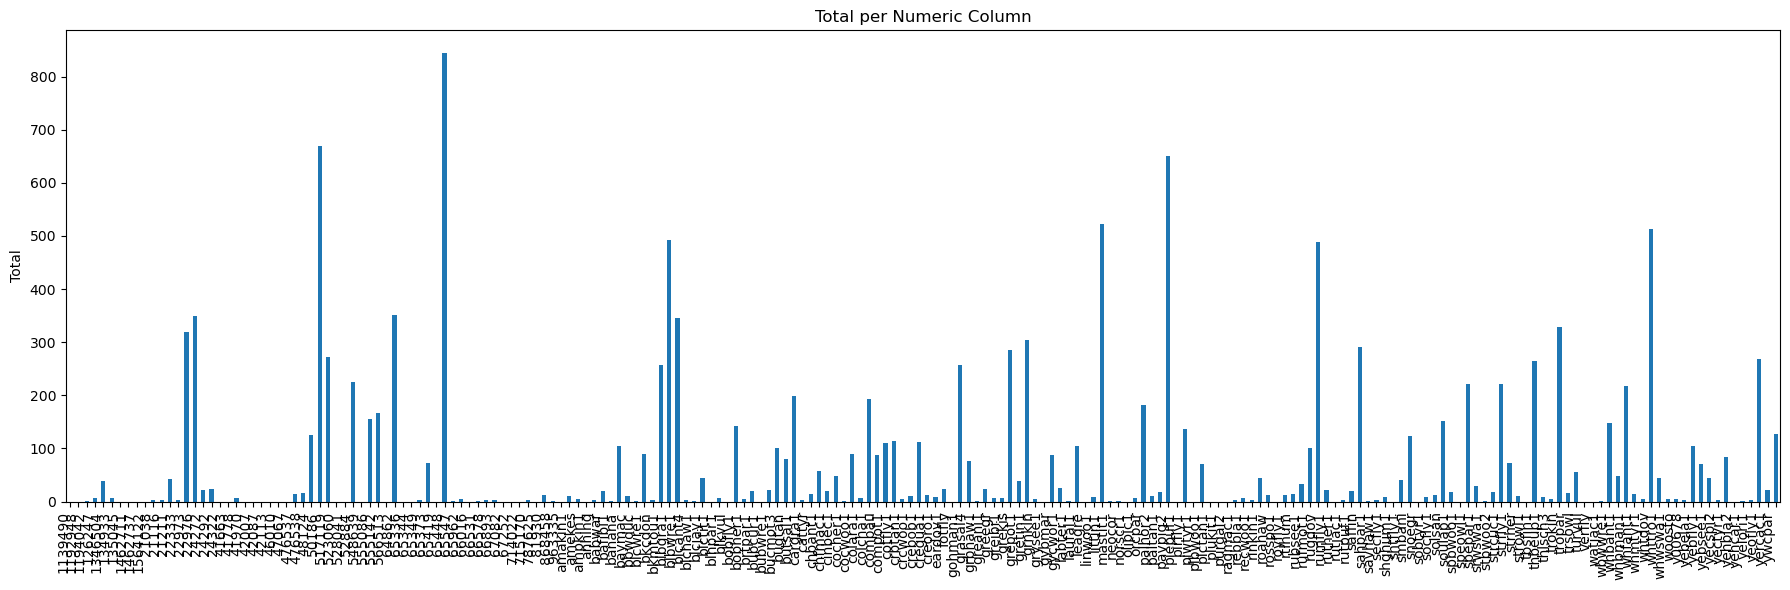

In [31]:
# Sum each numeric column
column_totals = df_binary.select_dtypes(include='number').sum()

import matplotlib.pyplot as plt

# Set a wider figure size
plt.figure(figsize=(18, 6))  # Width=12 inches, Height=6 inches

# Sum and plot
column_totals = df_binary.select_dtypes(include='number').sum()
column_totals.plot(kind='bar')
plt.ylabel('Total')
plt.title('Total per Numeric Column')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

In [32]:
df_binary.head()

,row_id,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
1,H27_20230421_155000_10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36,H14_20230430_050500_35,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
82,H79_20230513_221000_15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94,H71_20230520_194500_25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95,H71_20230520_194500_30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
df_binary['52884'].sum()

226

In [34]:
df_binary['compot1'].sum()

111

In [35]:
df = df_binary.copy()
df['end'] = (
    df['row_id']
    .str.extract(r'_(\d+)$')[0]   # Extract number at the end
    .astype(int) * 6 / 5          # Apply your scaling because the orignal notebook labelled wrong
).round().astype(int)  
df['start'] = df['end'] -6

In [36]:
# Example input column
import re
df['filename'] = df.apply(
    lambda row: re.sub(r'_[^_]+$', f"_{row['end']}.ogg", row['row_id']),
    axis=1
)

name_cols = df.columns.to_list()[1:-3]
df = df[['filename', 'row_id', 'start', 'end'] + name_cols]


In [37]:
df['row_id'] = df['row_id'].str.replace(r'_[^_]+$', '.ogg', regex=True)

In [38]:
df.head()

,filename,row_id,start,end,1139490,1192948,1194042,126247,1346504,134933,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
1,H27_20230421_155000_12.ogg,H27_20230421_155000.ogg,6,12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36,H14_20230430_050500_42.ogg,H14_20230430_050500.ogg,36,42,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
82,H79_20230513_221000_18.ogg,H79_20230513_221000.ogg,12,18,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94,H71_20230520_194500_30.ogg,H71_20230520_194500.ogg,24,30,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95,H71_20230520_194500_36.ogg,H71_20230520_194500.ogg,30,36,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
df.shape

(13587, 210)

In [40]:
import torchaudio
import soundfile as sf

def load_file(path):
    try:
        waveform, sr = torchaudio.load(path)
        y = waveform.numpy()
        if y.shape[0] == 2:
            y = y.mean(axis=0)
        else:
            y = y.squeeze()

        loaded_length = len(y)//sr
        if loaded_length <= 1:
            print(f'Warning, the loaded clip length is only {loaded_length} seconds for the file {path}')
        return y, sr
    except Exception as e:
        print(f"Error processing file {path}: {e}")
        return None, None


def process_group(row_id,
                  group, 
                 in_folder = paths.soundscapes_folder,
                 out_folder = paths.new_backgrounds,
                 default_sr = 32000):
    filename = row_id
    in_path = str(in_folder / filename)

    #print(in_path)
    y, sr = load_file(in_path)

    if y is not None:
        for _, row in group.iterrows():
            start=row.start * sr
            end = row.end * sr
            part = y[start:end]
            if len(part) >=1:
                out_path = str(out_folder / row.filename)
                if sr != default_sr:
                    num_samples = int(len(part) * default_sr / sr)
                    part = resample(part, num_samples)
                sf.write(out_path, part, default_sr)
    return

In [41]:
grouped = df.groupby('row_id')


#for row_id, group in tqdm(grouped):
    #print(f'Processing group: {row_id}')
#    process_group(row_id, group)

In [42]:
df = df[['filename'] + name_cols].reset_index(drop=True)

In [43]:
df.head()

,filename,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
0,H27_20230421_155000_12.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,H14_20230430_050500_42.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,H79_20230513_221000_18.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,H71_20230520_194500_30.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,H71_20230520_194500_36.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
df.to_parquet('/home/olly/Desktop/Kaggle_BC25/Data/Train_Metadata/background_labels.parquet')

In [45]:
df_check = pd.read_parquet('/home/olly/Desktop/Kaggle_BC25/Data/Train_Metadata/background_labels.parquet')
df_check.head()

,filename,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
0,H27_20230421_155000_12.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,H14_20230430_050500_42.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,H79_20230513_221000_18.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,H71_20230520_194500_30.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,H71_20230520_194500_36.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
df_check = df_check.loc[:, (df_check != 0).any(axis=0)]
df_check.columns.shape

(158,)

In [47]:
rarest

['rutpuf1',
 '42007',
 '1139490',
 '21116',
 '1194042',
 '47067',
 '476537',
 '476538',
 '523060',
 'piwtyr1',
 'plctan1',
 '24272',
 '24322',
 '24292',
 '41778',
 '528041',
 'turvul',
 '548639',
 '65349',
 '65419',
 'shghum1',
 'sahpar1',
 '555142',
 '64862',
 '65336',
 '65344',
 '81930',
 '868458',
 '714022',
 '787625',
 '963335',
 '66016',
 '65962',
 '65547',
 '41970',
 '1192948',
 '21038',
 '66531',
 '66578',
 '66893',
 '67082',
 '126247',
 '42113',
 '1346504',
 '134933',
 '42087',
 '1462711',
 '46010',
 '1462737',
 '1564122',
 'norscr1',
 '67252',
 'bubcur1',
 'ampkin1',
 'bafibi1',
 '566513',
 '135045',
 '65373',
 'grysee1',
 '715170',
 'blctit1',
 '555086',
 'whmtyr1',
 'royfly1',
 'cocher1',
 '48124',
 'olipic1',
 'woosto']

In [48]:
df_rare = df[['filename'] + rarest].copy()
df_rare.head()

,filename,rutpuf1,42007,1139490,21116,1194042,47067,476537,476538,523060,...,grysee1,715170,blctit1,555086,whmtyr1,royfly1,cocher1,48124,olipic1,woosto
0,H27_20230421_155000_12.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,H14_20230430_050500_42.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,H79_20230513_221000_18.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,H71_20230520_194500_30.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,H71_20230520_194500_36.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
df_rare.columns

Index(['filename', 'rutpuf1', '42007', '1139490', '21116', '1194042', '47067',
       '476537', '476538', '523060', 'piwtyr1', 'plctan1', '24272', '24322',
       '24292', '41778', '528041', 'turvul', '548639', '65349', '65419',
       'shghum1', 'sahpar1', '555142', '64862', '65336', '65344', '81930',
       '868458', '714022', '787625', '963335', '66016', '65962', '65547',
       '41970', '1192948', '21038', '66531', '66578', '66893', '67082',
       '126247', '42113', '1346504', '134933', '42087', '1462711', '46010',
       '1462737', '1564122', 'norscr1', '67252', 'bubcur1', 'ampkin1',
       'bafibi1', '566513', '135045', '65373', 'grysee1', '715170', 'blctit1',
       '555086', 'whmtyr1', 'royfly1', 'cocher1', '48124', 'olipic1',
       'woosto'],
      dtype='object')

In [50]:
df_rare.shape

(13587, 69)

In [51]:
df_rare = df_rare.loc[:, (df_rare != 0).any(axis=0)]
df_rare.head()

,filename,rutpuf1,21116,1194042,476537,476538,24272,24292,41778,65349,...,bafibi1,65373,715170,555086,whmtyr1,royfly1,cocher1,48124,olipic1,woosto
0,H27_20230421_155000_12.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,H14_20230430_050500_42.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,H79_20230513_221000_18.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,H71_20230520_194500_30.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,H71_20230520_194500_36.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
df_rare.shape

(13587, 34)

In [53]:
column_totals_df = df.sum(axis=0).to_frame(name="total")
column_totals_df

,total
filename,H27_20230421_155000_12.oggH14_20230430_050500_...
1139490,0
1192948,0
1194042,1
126247,6
...,...
yehcar1,1
yelori1,3
yeofly1,268
yercac1,22


In [54]:
import plotly.express as px

column_totals = df_rare.sum(axis=0).reset_index()
column_totals.columns = ['Category', 'Count']

fig = px.bar(column_totals, x='Category', y='Count', title='Column Totals')
fig.update_layout(xaxis_tickangle=-45)
fig.show()

In [55]:
65349, 'sahpar1', 81930, 868458, 65962, 65547, 21038, 66531, 66578, 66893, 126247, 1346504, 134933, 'bafibi1', 65373, 

(65349,
 'sahpar1',
 81930,
 868458,
 65962,
 65547,
 21038,
 66531,
 66578,
 66893,
 126247,
 1346504,
 134933,
 'bafibi1',
 65373)

In [56]:
label_counts_df = pd.read_csv(paths.data_folder / 'Train_Metadata/primary_label_counts.csv')
label_counts_df = label_counts_df[label_counts_df['primary_label'].isin(rarest)]
label_counts_df.head(40)

,Unnamed: 0,primary_label,total_count
133,133,royfly1,40
134,134,cocher1,40
137,137,olipic1,38
138,138,whmtyr1,34
141,141,blctit1,32
142,142,65373,32
144,144,ampkin1,28
145,145,woosto,27
146,146,bafibi1,27
147,147,555086,25


In [57]:
df_filtered = pd.read_parquet('/home/olly/Desktop/Kaggle_BC25/Data/Train_Metadata/background_labels.parquet')
df_filtered.head()

,filename,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
0,H27_20230421_155000_12.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,H14_20230430_050500_42.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,H79_20230513_221000_18.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,H71_20230520_194500_30.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,H71_20230520_194500_36.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
df_filtered.shape

(13587, 207)

In [59]:
#for name in rarest:
#    df_filtered = df_filtered[df_filtered[name]==0]

In [60]:
df_filtered.shape

(13587, 207)

In [61]:
df.to_parquet('/home/olly/Desktop/Kaggle_BC25/Data/Train_Metadata/background_labels.parquet')